In [1]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import random
import operator 
import math

import numpy as np
import pandas as pd
import datetime

# for reproduction
s = 0
random.seed(s)
np.random.seed(s)

In [2]:
PotionData = pd.read_csv("dataset1.csv")
PotionData = PotionData.rename({"Unnamed: 0": "N", "Moon Sugar": "X1", "Garlic": "X2", "Potion Quality": "Y"}, axis='columns')
PotionData.dropna(inplace=True)

In [3]:
PotionData

,N,X1,X2,Y
0,0,-1.644754,0.451184,0
1,1,-1.369659,3.317628,0
2,2,1.149700,1.899484,1
3,3,1.565192,2.581951,1
4,4,-1.296823,3.492819,0
...,...,...,...,...
995,995,-1.377697,2.900611,0
996,996,-1.595396,0.625938,0
997,997,3.120722,0.122990,1
998,998,-1.631190,0.376309,0


In [4]:
msk = np.random.rand(len(PotionData)) < 0.8
train = PotionData[msk]
holdout = PotionData[~msk]
X1 = train.X1.values
X2 = train.X2.values

Y = train.Y.values  # this is our target, now mapped to Y

print(X1)
print(X2)
print(Y)

[-1.64475379 -1.36965894  1.14969984  1.56519221 -1.29682254 -1.34538938
 -1.5460827  -1.79044117 -1.44867338 -1.68844369 -1.4537002  -1.70388486
  1.41098609 -1.40730972  1.67175025  1.73937088  2.42685598  1.37465367
  2.75294691 -1.51982603  2.89246651  2.38856405 -1.52009046 -1.64159676
 -1.67390975 -1.52702048 -1.62840663 -0.03721339 -1.31669223 -1.45899783
  2.50769867 -1.54767427 -1.47947512  1.64631769 -1.71220552  2.56374192
 -1.43238244  1.27538889  0.43846158  1.64509204  0.71904191  2.08821393
  0.53732255  0.54035566  0.87379728 -1.73225753  0.9193611   1.02524958
  1.39038108  0.8427266  -1.42514235  2.58753033 -1.57792714 -1.53909889
 -0.11827291 -1.6876502  -1.77616237  0.75822492 -1.19748163 -1.54992654
  1.53749955  1.48604531 -1.50126862 -1.29054784  1.06113753  1.45175098
  0.09846697  1.07244535 -1.37334773 -1.40082384 -1.69482799 -1.59438213
 -1.39618761 -1.48692214 -1.45281712 -0.67078404  1.09716276  1.98535998
 -1.64288827 -1.56290905  0.50124032 -1.49223883  1

In [5]:
import geppy as gep
pset = gep.PrimitiveSet('Main', input_names=['X1','X2'])

Примитивы

In [6]:
def protected_div(x1, x2):
    if abs(x2) < 1e-6:
        return 1
    return x1 / x2

pset.add_function(operator.add, 2)
pset.add_function(operator.sub, 2)
pset.add_function(operator.mul, 2)
pset.add_function(protected_div, 2)
pset.add_rnc_terminal()

In [8]:
from deap import creator, base, tools

creator.create("FitnessMin", base.Fitness, weights=(-1,))  # to minimize the objective (fitness)
creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMin)

In [9]:
h = 7          # head length
n_genes = 2    # number of genes in a chromosome
r = 10         # length of the RNC array
enable_ls = True # whether to apply the linear scaling technique

In [10]:
toolbox = gep.Toolbox()
toolbox.register('rnc_gen', random.randint, a=-10, b=10)   # each RNC is random integer within [-5, 5]
toolbox.register('gene_gen', gep.GeneDc, pset=pset, head_length=h, rnc_gen=toolbox.rnc_gen, rnc_array_length=r)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=operator.add)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_, pset=pset)

In [11]:
def evaluate(individual):
    """Evalute the fitness of an individual: MAE (mean absolute error)"""
    func = toolbox.compile(individual)
    
    # below call the individual as a function over the inputs
    
    # Yp = np.array(list(map(func, X)))
    Yp = np.array(list(map(func, X1, X2))) 
    
    # return the MSE as we are evaluating on it anyway - then the stats are more fun to watch...
    return np.mean((Y - Yp) ** 2),

In [12]:
def evaluate_ls(individual):
    """
    First apply linear scaling (ls) to the individual 
    and then evaluate its fitness: MSE (mean squared error)
    """
    func = toolbox.compile(individual)
    Yp = np.array(list(map(func, X1, X2)))
    
    # special cases which cannot be handled by np.linalg.lstsq: (1) individual has only a terminal 
    #  (2) individual returns the same value for all test cases, like 'x - x + 10'. np.linalg.lstsq will fail in such cases.
    # That is, the predicated value for all the examples remains identical, which may happen in the evolution.
    if isinstance(Yp, np.ndarray):
        Q = np.hstack((np.reshape(Yp, (-1, 1)), np.ones((len(Yp), 1))))
        (individual.a, individual.b), residuals, _, _ = np.linalg.lstsq(Q, Y)   
        # residuals is the sum of squared errors
        if residuals.size > 0:
            return residuals[0] / len(Y),   # MSE
    
    # regarding the above special cases, the optimal linear scaling w.r.t LSM is just the mean of true target values
    individual.a = 0
    individual.b = np.mean(Y)
    return np.mean((Y - individual.b) ** 2),

In [13]:
if enable_ls:
    toolbox.register('evaluate', evaluate_ls)
else:
    toolbox.register('evaluate', evaluate)

In [14]:
toolbox.register('select', tools.selTournament, tournsize=3)
# 1. general operators
toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=0.05, pb=1)
toolbox.register('mut_invert', gep.invert, pb=0.1)
toolbox.register('mut_is_transpose', gep.is_transpose, pb=0.1)
toolbox.register('mut_ris_transpose', gep.ris_transpose, pb=0.1)
toolbox.register('mut_gene_transpose', gep.gene_transpose, pb=0.1)
toolbox.register('cx_1p', gep.crossover_one_point, pb=0.3)
toolbox.register('cx_2p', gep.crossover_two_point, pb=0.2)
toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)
# 2. Dc-specific operators
toolbox.register('mut_dc', gep.mutate_uniform_dc, ind_pb=0.05, pb=1)
toolbox.register('mut_invert_dc', gep.invert_dc, pb=0.1)
toolbox.register('mut_transpose_dc', gep.transpose_dc, pb=0.1)
# for some uniform mutations, we can also assign the ind_pb a string to indicate our expected number of point mutations in an individual
toolbox.register('mut_rnc_array_dc', gep.mutate_rnc_array_dc, rnc_gen=toolbox.rnc_gen, ind_pb='0.5p')
toolbox.pbs['mut_rnc_array_dc'] = 1  # we can also give the probability via the pbs property

In [15]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [16]:
# size of population and number of generations
n_pop = 120
n_gen = 50

#100 3000

champs = 3

pop = toolbox.population(n=n_pop) # 
hof = tools.HallOfFame(champs)   # only record the best three individuals ever found in all generations

In [17]:
# start evolution
pop, log = gep.gep_simple(pop, toolbox, n_generations=n_gen, n_elites=1,
                          stats=stats, hall_of_fame=hof, verbose=True)

C:\Users\707\AppData\Local\Temp/ipykernel_17792/3470453066.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (individual.a, individual.b), residuals, _, _ = np.linalg.lstsq(Q, Y)


gen	nevals	avg     	std     	min      	max     
0  	120   	0.168426	0.091804	0.0146509	0.249911
1  	119   	0.10625 	0.0923406	0.0146509	0.249911
2  	119   	0.0923348	0.0907881	0.0146509	0.249911
3  	119   	0.0796686	0.0825799	0.0104361	0.249911
4  	119   	0.0771398	0.0818757	0.0104361	0.249911
5  	119   	0.0700177	0.0750694	0.00940575	0.249911
6  	119   	0.0820517	0.0856642	0.00940575	0.249911
7  	119   	0.0783808	0.0854761	0.00940575	0.249911
8  	119   	0.0742624	0.08251  	0.00940575	0.249911
9  	119   	0.0934686	0.0897456	0.00940575	0.249911
10 	119   	0.0887906	0.0883031	0.00940575	0.249911
11 	119   	0.0709716	0.0806566	0.00940575	0.249911
12 	119   	0.0782849	0.0818188	0.00864336	0.249911
13 	119   	0.0728997	0.0786329	0.00856821	0.249911
14 	119   	0.0921799	0.0912473	0.00856821	0.249911
15 	119   	0.0721949	0.0783233	0.00856821	0.249911
16 	119   	0.0700098	0.0719242	0.00847474	0.249911
17 	119   	0.0737932	0.0809916	0.00847474	0.249911
18 	119   	0.0699891	0.078709 	0.00847474	

In [18]:
print(hof[0])

add(
	mul(add(X1, X1), sub(protected_div(5, X1), add(-2, X1))),
	sub(sub(X1, X2), sub(protected_div(X1, -2), add(3, X1)))
)


In [19]:
# print the best symbolic regression we found:
best_ind = hof[0]
symplified_best = gep.simplify(best_ind)

if enable_ls:
    symplified_best = best_ind.a * symplified_best + best_ind.b

key= '''
Given training examples of

    X1, X2 POTIONS

we trained a computer using Genetic Algorithms to predict the 

    Y = POTION QUALITY

Our symbolic regression process found the following equation offers our best prediction:

'''

print('\n', key,'\t', str(symplified_best), '\n\nwhich formally is presented as:\n\n')

from sympy import *
init_printing()
symplified_best



 
Given training examples of

    X1, X2 POTIONS

we trained a computer using Genetic Algorithms to predict the 

    Y = POTION QUALITY

Our symbolic regression process found the following equation offers our best prediction:

 	 -0.10671344489015*X1**2 + 0.346818695892987*X1 - 0.0533567224450749*X2 + 0.856165599134772 

which formally is presented as:




C:\Users\707\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\707\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\707\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\707\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The MathtextBackendBit

In [20]:
 # we want to use symbol labels instead of words in the tree graph
rename_labels = {'add': '+', 'sub': '-', 'mul': '*', 'protected_div': '/'}  
gep.export_expression_tree(best_ind, rename_labels, 'data/numerical_expression_tree.png')

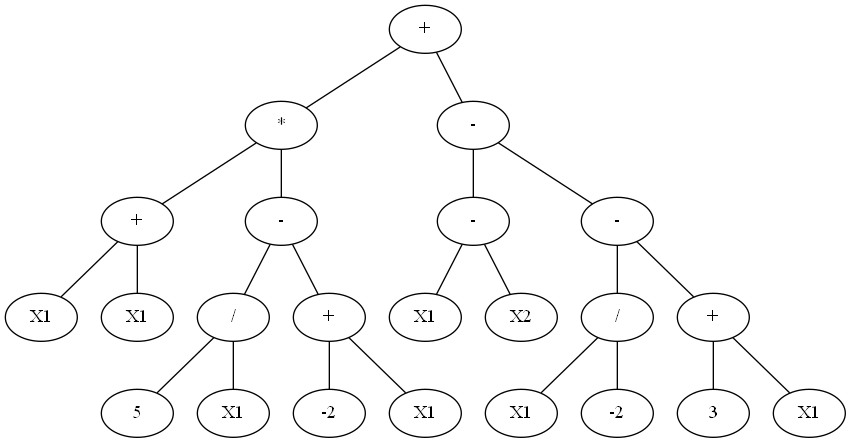

In [21]:
 # show the above image here for convenience
from IPython.display import Image
Image(filename='data/numerical_expression_tree.png')


In [22]:
def CalculateBestModelOutput(X1, X2, model):
    # pass in a string view of the "model" as str(symplified_best)
    # this string view of the equation may reference any of the other inputs, AT, V, AP, RH we registered
    # we then use eval of this string to calculate the answer for these inputs
    return eval(model) 

In [23]:
predY = CalculateBestModelOutput(holdout.X1, holdout.X2, str(symplified_best))

In [24]:
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.2f" % mean_squared_error(holdout.Y, predY))
print("R2 score : %.2f" % r2_score(holdout.Y, predY))

Mean squared error: 0.01
R2 score : 0.97


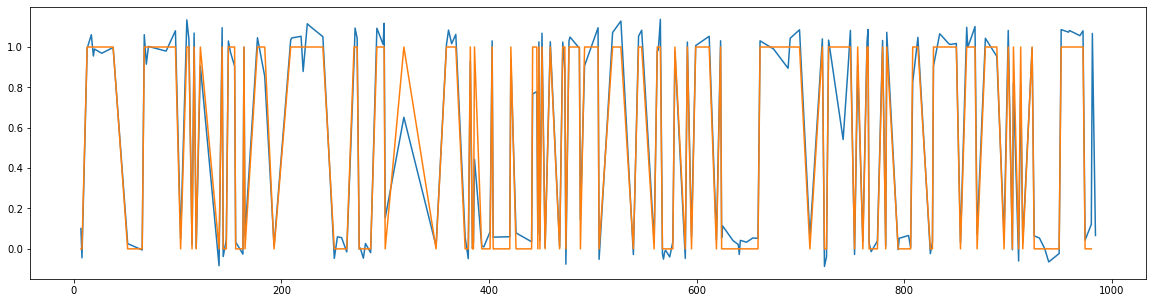

In [25]:
from matplotlib import pyplot
pyplot.rcParams['figure.figsize'] = [20, 5]
plotlen=200
pyplot.plot(predY.head(plotlen))       # predictions are in blue
pyplot.plot(holdout.Y.head(plotlen-2)) # actual values are in orange
pyplot.show()